# 1 Collecting and processing data

In [5]:
from typing import List
import numpy as np
from collections import Counter
import random
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import sklearn.metrics as metrics
from PIL import Image
import os


In [6]:
import os
fine_tune_DANABERT_using_pretrained_model = True # using DNABERT using a pretrained model

### 1-1 For E_coli_k12 dataset:
  - Use https://regulondb.ccg.unam.mx/menu/download/datasets/index.jsp, and directly download: E. coli K-12 genome sequence raw format

  - Or use !wget http://regulondb.ccg.unam.mx/menu/download/datasets/files/E_coli_K12_MG1655_U00096.3.txt
    

#### 1-1-1 Details of E Coi bactrium dataset:
  - The genome sequence of E. coli K-12 bacterium, genome version U00096.3, is loaded in fasta format
  - One line in the gene file represents one gene and includes the left and right end coordinates of each gene, DNA strand direction (forward or reverse) and the nucleotide sequence of the gene.
  - There is also other information such as the name and identifier of the gene, but those are not used in the experiments.


#### 1-1-2 General guidline for pre-processing of E coli bactrium genome
  - The lines of the E. coli genome file are concatenated to one long string, containing a total of 4641652 nucleotide characters.
  - First, 21 gene sequences with no coordinates and nucleotide sequences are left out.
  - The lines are then ordered based on the left end coordinate of each gene, and only coordinates, directions and nucleotide sequences are included.
  -  The ground truth data of E. coli genes thus includes 4665 gene sequences and coordinates, 2297 in the forward direction and 2368 in the reverse direction of the DNA strand.


#### 1-1-3 The practice to pre-process the data
  - Genome data input for the pre-trained DNABERT model has to be divided into context windows of length w < 512. 
  - Each window has to be in the k-mer form, k being 3, 4, 5or 6. For example, if k = 3 and one of the windows is ACCGT with w = 5, the k-mer
representation is ACC CCG CGT. 
  - The model is then able to transform each k-mer into a numerical token using the dictionary of all possible nucleotide combinations of length k and corresponding integers. For instance in case of k = 3 there are 4X4X4 = 64
tokens, and when k = 6 there are total of 4^6 = 4096 possible tokens. 
  - Eventually, every context window has its own representation consisting of a list of tokens.

In [7]:
kmer_val=6
windows_vals=[75]
method_val=1 

In [8]:
import os

# Genome sequence of E. coli K-12 bacterium, genome version U00096.3, is loaded in fasta format
!wget -q http://regulondb.ccg.unam.mx/menu/download/datasets/files/E_coli_K12_MG1655_U00096.3.txt

# Gene coordinates (ground truth)
!wget -q https://regulondb.ccg.unam.mx/menu/download/datasets/files/Gene_sequence.txt  --no-check-certificate

# Just in case already the files existed, and we downloaded it for the second time
if os.path.isfile("E_coli_K12_MG1655_U00096.3.txt.1"):
  os.remove("E_coli_K12_MG1655_U00096.3.txt.1")
  print("Since the downloded file already existed, it is removed.")

if os.path.isfile("Gene_sequence.txt.1"):
  os.remove("Gene_sequence.txt.1")
  print("Since the downloded file already existed, it is removed.")


**Downloading the  pretrained DNA model**

In [9]:
if fine_tune_DANABERT_using_pretrained_model:
  if os.path.exists("./pretrained_DNA/"):
    !rm -r "./pretrained_DNA/"
  os.makedirs("./pretrained_DNA/")
  print("A new directory is created to hold the pretrained DNAERT model.")
  
  !gdown -q https://drive.google.com/u/0/uc?id=1BJjqb5Dl2lNMg2warsFQ0-Xvn1xxfFXC&export=download&confirm=t&uuid=574dd7fc-207b-43c4-b502-ab6a52549838&at=ALgDtswq3dLLBv3bezvOuM8dlJG-:1679328206346

  !unzip -q 6-new-12w-0.zip -d "./pretrained_DNA/"
  !rm 6-new-12w-0.zip


A new directory is created to hold the pretrained DNAERT model.


**Downloading the genome (genomic data) and its coordinate**

  - Coordinate is another term, where and what part of genome is gene (or coding section)
  - gt = ground truth

In [10]:
def _get_data(genome_seq_dir: str = "./E_coli_K12_MG1655_U00096.3.txt", gt_dir: str = "./Gene_sequence.txt"):
    """
    gt_dir: ground_truth genome sequence includes info such as gene coordination, start idx, end idx, ...
            We need to clean up the ground_truth data and eliminate those with no coordination info

    genome_seq_dir: The genome sequence.
            Here we want to focus only on a specific genome for a bacteria (Ecoli K-12
    """
    gt_genome_seq_data = []
    with open(gt_dir, 'r') as f:
        gt_lines = f.readlines()
        for line in gt_lines:
            if line[0] != '#': # ignore the commented-out lines
                tab_separated_lst = line.split("\t")
                gt_genome_seq_data.append(tab_separated_lst)
    print(f'Total # of ground-truth genes (sequences): {len(gt_genome_seq_data)}')  # 4686

    # 2. Put in order
    def order(elem):
        r = elem[0]
        if len(r) > 0:
            return int(r)
        else:
            return 0

    # We are only interested in genome sequences
    # Genes with no␣coordinates are left out. d[2] in every list in gt_genome_seq_data is the starting idx for gene
    # we only want to keep starting_idx, end_idx, and if it is "forwarding" "backward-ing"
    gt_genome_seq_data_ordered = [d[2:6] for d in gt_genome_seq_data if len(d[2]) > 0]
    gt_genome_seq_data_ordered.sort(key=order)
    print(f'Genes with no coordinates removed, total amount now: {len(gt_genome_seq_data_ordered)}')
    # Separate sets for forward and reverse genes
    gt_genome_seq_data_forward = [d for d in gt_genome_seq_data_ordered if d[2] == "forward"]
    gt_genome_seq_data_reverse = [d for d in gt_genome_seq_data_ordered if d[2] == "reverse"]
    print(f'Forward genes: {len(gt_genome_seq_data_forward)}')
    print(f'Reverse genes: {len(gt_genome_seq_data_reverse)}')

    # ----------------------------------------------------------------------------------
    # Read the genome sequence to one string of ~4.6 million length
    # The one giant string genome seq is initially stored in ~61-62 K lists, majority of which of length 75
    ecoli_dir = genome_seq_dir

    with open(ecoli_dir, 'r') as f:
        ecoli_lines = f.readlines()[1:]
        line_length = len(ecoli_lines[50])
        ecoli_lines = [l[:line_length - 1] for l in ecoli_lines]

    print(f'{len(ecoli_lines)} lines')

    ecoli = ''
    for line in ecoli_lines:
        ecoli += line

    print(f'{len(ecoli)} nucleotides in ecoli genome')

    return ecoli, gt_genome_seq_data_ordered, gt_genome_seq_data_forward, gt_genome_seq_data_reverse


In [19]:

class PreProcessData():
    def __init__(self, genome, gt_gen_seq_coor, train_fraction=0.7, windows=[75], k_mer_val=3,
                genome_name="ecoli"):
        self.train_fraction: float = train_fraction
        self.windows = windows
        self.k_mer_val = k_mer_val
        self.genome_name = genome_name
        self.method = 1 # What method to use to label (0 vs 1) test dataset, when it is partially 1 and partially 0
        self.shuffle = True,
        self.sliding_window = True
        self.genome: str = genome
        self.gt_gen_seq_coor: List[List[str]] = gt_gen_seq_coor

    def _label_genome(self):
        """
        Assigns labels according to the gene coordinates (start and end index of ground-truth genome)
        """
        coordinates = [(int(c[0]), int(c[1])) for c in self.gt_gen_seq_coor]
        labels = np.zeros(len(self.genome), dtype=int)
        for i, c in enumerate(coordinates):
            # Set all gene labels to 1, between the start_idx (c[0]) till end_idx (c[1])
            labels[c[0] - 1:c[1]] = 1
        c = Counter(labels)
        print(f'Zeros-label fraction of the total labels: {c[0] / (c[0] + c[1]):.4f}')
        return labels

    def _get_train_test_genome_and_label(self):
        """
        Make train and test sets from the genome and ground truth coordinates
        """
        self.labels: List[int] = self._label_genome()
        # Find the test/train border index
        idx: int = int(len(self.labels) * self.train_fraction)
        self.genome_train: str = self.genome[:idx]
        self.genome_label_train: List[List[str]] = self.labels[:idx]
        self.genome_test: str = self.genome[idx:]
        self.genome_label_test: List[List[str]] = self.labels[idx:]

    def _make_kmers(self, data):
        """
        Forming the k-mer representations for a nucleotide sequence
        """
        k = self.k_mer_val
        if len(data) % k != 0 and not self.sliding_window:
            print('Check that seq length is 0 mod k')
        output = ''
        if self.sliding_window:
            for i in range(0, len(data) - k + 1):
                output += data[i:i + k]
                output += ' '
        else:
            for i in range(0, len(data) - k + 1, k):
                output += data[i:i + k]
                output += ' '
        return output[:-1]

    def _make_train_sequences(self, seq_len) -> List[str]:
        """
        Train sequences and test sequences are made differently
        Train data is first splitted by labels, and then every sequence is transformed into k-mers
        and then into sequences of desired window size (seq_len)
        """
        seq_len = seq_len - self.k_mer_val + 1
        labels = self.genome_label_train
        labels = np.split(labels, np.where(np.diff(labels[:]))[0] + 1)
        seqs = []
        zeros = 0
        idx = 0
        for l in labels:
            l_len = len(l)
            idx += l_len
            # Sequences shorter than k are left out (tokenizer does not have tokens for them)
            if l_len >= self.k_mer_val:
                g = self.genome_train[idx - l_len:idx]
                kmers = self._make_kmers(g).split(' ')

                for i in range(0, l_len - 1, seq_len):
                    seq = ' '.join(kmers[i:i + seq_len])
                    label = int(l[0])
                    if label == 0:
                        zeros += 1
                    line = ('{}{}{}{}'.format(seq, '\t', label, '\n'))
                    seqs.append(line)
        print(f'Zero-label count in the train set: {zeros / len(seqs)}')
        return seqs

    def _make_test_sequences(self, seq_len) -> List[str]:
        """
        Test data is first splitted according to desired window size (seq_len).
        """
        seqs = []
        zeros = 0
        for i in range(0, len(self.genome_test) - seq_len + 1, seq_len):
            seq = self._make_kmers(self.genome_test[i:i + seq_len])

            # Only sequences fully inside the gene are labeled as 1
            if self.method == 2:
                if sum(self.genome_label_test[i:i + seq_len]) == seq_len:
                    label = 1
                else:
                    label = 0
                    zeros += 1
            # If one or more nucleotides in sequence are inside the gene, label as 1
            elif self.method == 3:
                if sum(self.genome_label_test[i:i + seq_len]) > 0:
                    label = 1
                else:
                    label = 0
                    zeros += 1
            # If more than half of nucleotides are inside the gene, label as 1
            else:
                if sum(self.genome_label_test[i:i + seq_len]) > seq_len / 2:
                    label = 1
                else:
                    label = 0
                    zeros += 1
            line = ('{}{}{}{}'.format(seq, '\t', label, '\n'))
            seqs.append(line)
        print(f'Zeros account of the total labels in test set: {zeros / len(seqs)}')
        return seqs

    def _write_test_and_dev_files(self, seq_len, path):
        """
        Write the .tsv files in a desired path
        """
        train_data: List[str] = self._make_train_sequences(seq_len)
        test_data: List[str] = self._make_test_sequences(seq_len)
        print(f'# of train seq: {len(train_data)}: windoes-length of {seq_len} each into k_mer length of {self.k_mer_val}')
        print(f'# of test seq: {len(test_data)}: windoes-length of {seq_len} each into k_mer length of {self.k_mer_val}')
        header = ['sequence label\n']
        if self.shuffle:
            np.random.seed(123)
            np.random.shuffle(train_data)
        train = header + train_data
        test = header + test_data

        if not os.path.exists('./' + path):
            os.makedirs('./' + path)
        train_dir = path + 'train.tsv'
        test_dir = path + 'dev.tsv'

        with open(train_dir, 'w') as f_output:
            for line in train:
                f_output.write(line)

        with open(test_dir, 'w') as f_output:
            for line in test:
                f_output.write(line)

        return train_data, test_data

    def make_datasets(self):
        """
        Function for making multiple datasets
        """
        self._get_train_test_genome_and_label()
        
        for w in self.windows:
            print(f'window={w}, k={self.k_mer_val}')
            trains, tests = self._write_test_and_dev_files(
                                                seq_len=w,
                                                path=f'{self.genome_name}_data/{self.k_mer_val}/method{self.method}/{w}/',
            )

            globals()[f'train_{self.k_mer_val}_labels_{w}'] = trains
            globals()[f'test_{self.k_mer_val}_labels_{w}'] = tests


In [20]:
# -----------------------------------------------------------------------------------
# Test1
# testing making k_mer's representations for the nucleotide sequence
fake_genome='ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGACC'
fake_gt_gen_seq_coor = [(3, 8), (11, 15), (14, 19)]
preProcessObj1 = PreProcessData(genome=fake_genome, gt_gen_seq_coor=fake_gt_gen_seq_coor,
                               train_fraction=1.0, windows=[75], k_mer_val=6,
                                genome_name="fake_ecoli")
k_mer_ed_represntation = preProcessObj1._make_kmers(data=fake_genome)
print(k_mer_ed_represntation)

ATGAAA TGAAAC GAAACG AAACGC AACGCA ACGCAT CGCATT GCATTA CATTAG ATTAGC TTAGCA TAGCAC AGCACC GCACCA CACCAC ACCACC CCACCA CACCAT ACCATT CCATTA CATTAC ATTACC TTACCA TACCAC ACCACC CCACCA CACCAC ACCACC CCACCA CACCAT ACCATC CCATCA CATCAC ATCACC TCACCA CACCAT ACCATT CCATTA CATTAC ATTACC TTACCA TACCAC ACCACA CCACAG CACAGG ACAGGT CAGGTA AGGTAA GGTAAC GTAACG TAACGG AACGGT ACGGTG CGGTGC GGTGCG GTGCGG TGCGGG GCGGGC CGGGCT GGGCTG GGCTGA GCTGAC CTGACC


In [21]:
# Test2: Labeling task: Those nodes/letters in below ecoli_genome gets label as 1 for indices between (3, 8), (11, 15), (14, 19)
fake_genome = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
fake_gt_seq_data_ordered = [(3, 8), (11, 15), (14, 19)] # ordered based on start index --> 3 < 11 < 14
preProcessObj2 = PreProcessData(genome=fake_genome, gt_gen_seq_coor=fake_gt_seq_data_ordered,
                               train_fraction=1.0, windows=[75], k_mer_val=6,
                                genome_name="fake_ecoli")
fake_labels = preProcessObj2._label_genome()
print(fake_labels)

Zeros-label fraction of the total labels: 0.4231
[0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]


**Balancing label 0 and 1**:
If we want to balance two classes, we might want to only consider the forward_gene or just the backward_gene. If that case, we need to consider the 3rd or 4th output of the "_get_data" method.

In [22]:
# Test 3
ecoli_genome, gt_gen_seq_coor, _, _ = _get_data(genome_seq_dir="./E_coli_K12_MG1655_U00096.3.txt", gt_dir="./Gene_sequence.txt")
preProcessObj3 = PreProcessData(genome=ecoli_genome, gt_gen_seq_coor=gt_gen_seq_coor,
                               train_fraction=0.7, windows=[75], k_mer_val=6,
                                genome_name="ecoli")
preProcessObj3.make_datasets()

Total # of ground-truth genes (sequences): 4747
Genes with no coordinates removed, total amount now: 4726
Forward genes: 2328
Reverse genes: 2398
61889 lines
4641652 nucleotides in ecoli genome
Zeros-label fraction of the total labels: 0.1113
window=75, k=6
Zero-label count in the train set: 0.13182439741208646
Zeros account of the total labels in test set: 0.10766993428848433
# of train seq: 48997: windoes-length of 75 each into k_mer length of 6
# of test seq: 18566: windoes-length of 75 each into k_mer length of 6


In [23]:
test_label = preProcessObj3.genome_label_test

In [24]:
print(len(test_label))

1392496


# 2 Cloning DNABERT


### 2-1 Setting Conda env for Colab 


- In line 35 in run_finetune.py, change "from tqdm import tqdm" to "from tqdm . notebook import tqdm"

- In the requirements.tx: Fix the version for "sentencepiece==0.1.94"

- In setup.py, in DNABERT package, "tokenizers == 0.5.0" is noted. This gives an error for installation in Colab. Change it to "tokenizers == 0.11.0"

In [27]:
#importing the regex module
import re
#defining the replace method
def replace(filePath, text, subs, flags=0):
   #open the file
   with open(file_path, "r+") as file:
       #read the file contents
       file_contents = file.read()
       text_pattern = re.compile(re.escape(text), flags)
       file_contents = text_pattern.sub(subs, file_contents)
       file.seek(0)
       file.truncate()
       file.write(file_contents)

### 2-2 Clone the DNABERT

In [28]:
!git clone https://github.com/jerryji1993/DNABERT.git

fatal: destination path 'DNABERT' already exists and is not an empty directory.


In [29]:
file_path="./DNABERT/setup.py"
text="tokenizers == 0.5.0"
subs="tokenizers"
#subs="tokenizers == 0.11.0"
#calling the replace method
replace(file_path, text, subs)


file_path="./DNABERT/examples/run_finetune.py"
text="from tqdm import tqdm, trange"
subs="from tqdm.notebook import tqdm, trange"
#calling the replace method
replace(file_path, text, subs)

file_path="./DNABERT/examples/requirements.txt"
text="sentencepiece==0.1.91"
subs="sentencepiece==0.1.94"
#calling the replace method
replace(file_path, text, subs)

In [30]:
# remove -q, if you want to see the detailed messages for installations
!pip install -q --upgrade pip
!pip install -q tokenizers  #!pip install tokenizers==0.11.0
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.9 MB/s eta 0:00:00


In [31]:
cd ./DNABERT/

/content/DNABERT


In [32]:
# remove -q, if you want to see the detalied messages regarding the installations
!pip install -q --editable .

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 70.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 11.6 MB/s eta 0:00:00


In [33]:
cd ./examples/

/content/DNABERT/examples


In [34]:
!pip install -q -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 102.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.5/507.5 kB 38.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 42.7 MB/s eta 0:00:00


### 2-3 Running fin-tunning code

  - "do_train" flag must be True
  - The paths to the data and model should be set

In [35]:
# making sure we are at the right folder to run the run_finetube.py
!ls

compute_result.py      requirements.txt  run_pretrain.py  scripts
data_process_template  run_finetune.py	 sample_data	  visualize.py


In [36]:
import os
os.environ['KMER'] = str(kmer_val)
k = os.getenv("KMER")
os.environ["TOKENIZER_NAME"] = f"dna{k}"
os.environ['MODEL_PATH'] = f"../../pretrained_DNA/{k}-new-12w-0/"
os.environ['DATA_PATH'] = f"../../ecoli_data/{k}/method1/75/"
os.environ['OUTPUT_PATH'] = f"../../output/{k}/"
os.environ['PREDICTION_PATH'] = f"../../prediction/{k}/"

!echo $KMER
!echo $TOKENIZER_NAME
!echo $MODEL_PATH
!echo $DATA_PATH
!echo $OUTPUT_PATH
!echo $PREDICTION_PATH


6
../../pretrained_DNA/6-new-12w-0/
../../ecoli_data/6/method1/75/
../../output/6/
../../prediction/6/
dna6


In [37]:
output_dir = os.getenv("OUTPUT_PATH")
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

pred_dir = os.getenv("PREDICTION_PATH")
if not os.path.exists(pred_dir):
  os.makedirs(pred_dir)
  

In [ ]:
!python run_finetune.py \
    --model_type "dna" \
    --tokenizer_name $TOKENIZER_NAME \
    --model_name_or_path $MODEL_PATH \
    --task_name "dnaprom" \
    --do_train \
    --data_dir $DATA_PATH \
    --max_seq_length 75 \
    --per_gpu_eval_batch_size 16 \
    --per_gpu_train_batch_size 16 \
    --learning_rate 1e-6 \
    --num_train_epochs 2.0 \
    --output_dir $OUTPUT_PATH \
    --predict_dir $OUTPUT_PATH \
    --logging_steps 100 \
    --save_steps 60000 \
    --warmup_percent 0.06 \
    --hidden_dropout_prob 0.1 \
    --overwrite_output \
    --weight_decay 0.01 \
    --n_process 8

2023-05-03 23:58:46.789454: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 23:58:48.467006: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
05/03/2023 23:58:54 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
05/03/2023 23:58:54 - INFO - transformers.configuration_utils -   loading configuration file ../../pretrained_DNA/6-new-12w-0/config.json
05/03/2023 23:58:54 - INFO - transformers.configuration_utils -   Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "do_sample": false,
  "eos_token_ids": 0,
  "finetuning_task": "dnaprom",
  

### 2-4 Running prediction code

In [ ]:
!python run_finetune.py \
    --model_type "dna" \
    --tokenizer_name $TOKENIZER_NAME \
    --model_name_or_path $MODEL_PATH \
    --task_name "dnaprom" \
    --do_predict \
    --data_dir $DATA_PATH \
    --max_seq_length 75 \
    --per_gpu_eval_batch_size 16 \
    --per_gpu_train_batch_size 16 \
    --learning_rate 1e-6 \
    --num_train_epochs 3.0 \
    --output_dir $OUTPUT_PATH \
    --predict_dir $PREDICTION_PATH \
    --logging_steps 100 \
    --save_steps 60000 \
    --warmup_percent 0.06 \
    --hidden_dropout_prob 0.1 \
    --overwrite_output \
    --weight_decay 0.01 \
    --n_process 8

2023-05-04 00:22:17.911960: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 00:22:18.988455: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
05/04/2023 00:22:20 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
05/04/2023 00:22:20 - INFO - transformers.configuration_utils -   loading configuration file ../../pretrained_DNA/6-new-12w-0/config.json
05/04/2023 00:22:20 - INFO - transformers.configuration_utils -   Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "do_sample": false,
  "eos_token_ids": 0,
  "finetuning_task": "dnaprom",
  

In [ ]:
pred_dir + "pred_results.npy"

'../../prediction/6/pred_results.npy'

In [ ]:
xx = np.load(pred_dir + "pred_results.npy")

In [ ]:
xx

array([0.97528607, 0.9774318 , 0.97362006, ..., 0.9508169 , 0.97763693,
       0.9488902 ], dtype=float32)

In [ ]:
len(xx)

18566

### 2-5 Running visualization code

In [ ]:
# !python run_finetune.py \
#     --model_type "dna" \
#     --tokenizer_name $TOKENIZER_NAME \
#     --model_name_or_path $MODEL_PATH \
#     --task_name "dnaprom" \
#     --do_visualize \
#     --visualize_data_dir $DATA_PATH \
#     --visualize_models $KMER \
#     --data_dir $DATA_PATH \
#     --max_seq_length 75 \
#     --per_gpu_eval_batch_size 16 \
#     --per_gpu_train_batch_size 16 \
#     --learning_rate 1e-6 \
#     --num_train_epochs 3.0 \
#     --output_dir $OUTPUT_PATH \
#     --predict_dir $PREDICTION_PATH \
#     --logging_steps 100 \
#     --save_steps 60000 \
#     --warmup_percent 0.06 \
#     --hidden_dropout_prob 0.1 \
#     --overwrite_output \
#     --weight_decay 0.01 \
#     --n_process 8

# 3 Evaluation

In [ ]:
# Change the predictions from floats in range [0,1] into labels 0 or 1
def make_predicted_labels(data, seq_len, th=0.5):
  labels = []
  probabs = []
  for d in data:
    if d>th:
      for i in range(seq_len):
        labels.append(1)
        probabs.append(d)
    else:
      for i in range(seq_len):
        labels.append(0)
        probabs.append(d)
  return labels, probabs


In [ ]:
import shutil

# Visualize the distribution of predicted values.
def plot_distribution(data, th):
  vals = [int(v*1000) for v in data]
  counts = Counter(vals)
  keys = counts.keys()
  values = counts.values()
  c = np.zeros(1000)
  for key, value in counts.items():
    c[key]=value
    
  fig = plt.figure(figsize = (6,6))
  plt.plot(c, label='predictions')
  plt.yscale('log')
  fig.suptitle('Distribution of predictions')
  plt.axvline(x=th*1000, color='red', label='threshold')
  plt.legend(['predictions', 'threshold'])
  locs, labels = plt.xticks() # Get the current locations and labels.
  stp=1/(len(locs)-2)
  lbls = [x/1000 for x in locs]
  plt.xticks(ticks=locs[1:len(locs)-1], labels=lbls[1:len(lbls)-1])
  if os.path.exists("./figures/plots/"):
    shutil.rmtree("./figures/plots/")
  os.makedirs("./figures/plots/")
  plt.savefig("./figures/plots/"+"distribution.png")


In [ ]:
import shutil

# Visualize the TP, TN, FP and FN counts
def plot_confusion(tp,tn,fp,fn):
  results = np.array([[tn,fp], [fn,tp]])
  df_cm = pd.DataFrame(results)
  strings = np.asarray([['TN', 'FP'], ['FN', 'TP']])
  labels = (np.asarray(["{0}: {1}".format(string, value)   for string, value in zip(strings.flatten(),  results.flatten())]) ).reshape(2, 2)
  fig = plt.figure(figsize = (7,6))
  sn.set(font_scale=2)
  sn.heatmap(df_cm, annot=labels, fmt="", cmap="YlGn", xticklabels=False, yticklabels=False)
  fig.suptitle('Confusion matrix')
  plt.xlabel("Predictions")
  plt.ylabel("Actual labels")
  if os.path.exists("./figures/plots/"):
    shutil.rmtree("./figures/plots/")
  os.makedirs("./figures/plots/")
  plt.savefig("./figures/plots/"+"confusion.png")


In [ ]:
# Show Matthews correlation coefficient (MCC curve
from sklearn import metrics
import shutil

def plot_roc(gt_labels, probas):
  fpr, tpr, threshold = metrics.roc_curve(gt_labels, probas)
  fig=plt.figure(figsize = (6,6))
  plt.plot(fpr, tpr)
  fig.suptitle('ROC')
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.tight_layout(pad=0.5)
  if os.path.exists("./figures/plots/"):
    shutil.rmtree("./figures/plots/")
  os.makedirs("./figures/plots/")
  plt.savefig("./figures/plots/"+"roc.png")


In [ ]:
# Save loss values from the logs and read them from the file
def get_loss(path):
  data = []
  avg = 0
  with open(path, 'r') as f:
    lines = f.readlines()
    #print(lines)
    for line in lines:
      if line[0]=='{':
        line = line[:-1]
        #print(line)
        data.append(eval(line))
      elif len(line)>5:
        #print(line)
        line = line.split(' ')
        avg = float(line[-1])
  rates = [x.get('learning_rate') for x in data]
  losses = [x.get('loss') for x in data]
  steps = [x.get('step') for x in data]
  return steps, losses, avg

In [ ]:
# Visualize the model performation bu showing the loss values during the training
def plot_loss(path):
  steps, losses, avg = get_loss(path)
  fig=plt.figure(figsize=(6, 6))
  plt.plot(steps, losses, label='training loss')
  plt.axhline(y=avg, color='red', label='avg loss')
  plt.legend(['training loss', f'avg loss {avg:.4f}'])
  plt.xlabel("Steps")
  fig.suptitle(f'Loss')
  plt.tight_layout(pad=0.5)
  plt.savefig('figures/plots/loss.png')
  #plt.plot(steps, rates)

In [ ]:
# Combine and save the four images into one.
def make_image(path):
  images = [Image.open(x) for x in ['figures/plots/distribution.png',
  'figures/plots/confusion.png',
  'figures/plots/roc.png',
  'figures/plots/loss.png']]
  widths, heights = zip(*(i.size for i in images))
  total_width = sum(widths)
  max_height = max(heights)
  new_im = Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for i, im in enumerate(images):
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]
    new_im.save(path)



In [ ]:
# Calculate the evaluation metrics and show the plots
def evaluate(datapath, losspath, seq_len, test_labels, img_name, th=0.5):
  data = np.load(datapath)
  print(f'Predicted values are between {np.min(data):.4f} and {np.max(data):.4f}.')
  pr_labels, probabs = make_predicted_labels(data, seq_len, th)
  print(f'Count of predicted labels: {len(pr_labels)}')
  print(f'Count of gt labels: {len(test_labels)}')
  # Chacking that the label lengts match
  if len(test_labels)-len(pr_labels)>seq_len:
    print('Wrong test labels!')

  # TP, TN, FP and FN:
  mismatches, tp, tn, fp, fn = 0, 0, 0, 0, 0
  for i in range(len(pr_labels)):
    if pr_labels[i] != test_labels[i]:
      mismatches+=1
    if pr_labels[i] == 1 and test_labels[i] == 1:
      tp+=1
    elif pr_labels[i] == 0 and test_labels[i] == 0:
      tn+=1
    elif pr_labels[i] == 1 and test_labels[i] == 0:
      fp+=1
    elif pr_labels[i] == 0 and test_labels[i] == 1:
      fn+=1
  
  # Precision and recall:
  if tp+fp == 0:
    prec = 0.5
  else:
    prec = tp/(tp+fp)
  if tp+fn==0:
    rec=0.5
  else:
    rec = tp/(tp+fn)

  mcc_denom = (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
  if mcc_denom == 0:
    mcc_denom = 1
    
  mcc = (tp*tn-fp*fn)/mcc_denom**.5
  print(f'Accuracy: {1-mismatches/len(test_labels):.4f}')
  print(f'MCC: {mcc:.4f}')
  print(f'F1-score: {2*prec*rec/(prec+rec):.4f}')
  print(f'Precision: {prec:.4f}')
  print(f'Recall: {rec:.4f}')
  plot_distribution(data, th)
  plot_confusion(tp,tn,fp,fn)
  plot_roc(test_labels[:len(probabs)], probabs)
  # plot_loss(losspath)
  # make_image('figures/plots/ecoli/'+img_name)


In [ ]:
file_loc = "../../prediction/6/pred_results.npy"
test_labels = preProcessObj3.genome_label_test

In [ ]:
xx= np.load(file_loc)
xx

array([0.97528607, 0.9774318 , 0.97362006, ..., 0.9508169 , 0.97763693,
       0.9488902 ], dtype=float32)

Predicted values are between 0.3130 and 0.9850.
Count of predicted labels: 1392450
Count of gt labels: 1392496
Accuracy: 0.8900
MCC: 0.1873
F1-score: 0.9412
Precision: 0.8972
Recall: 0.9897


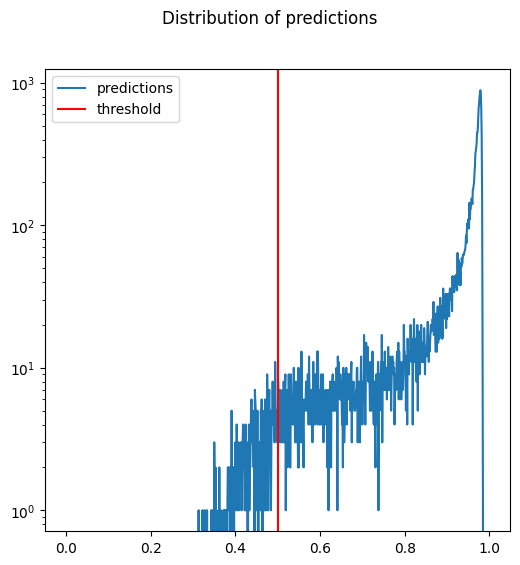

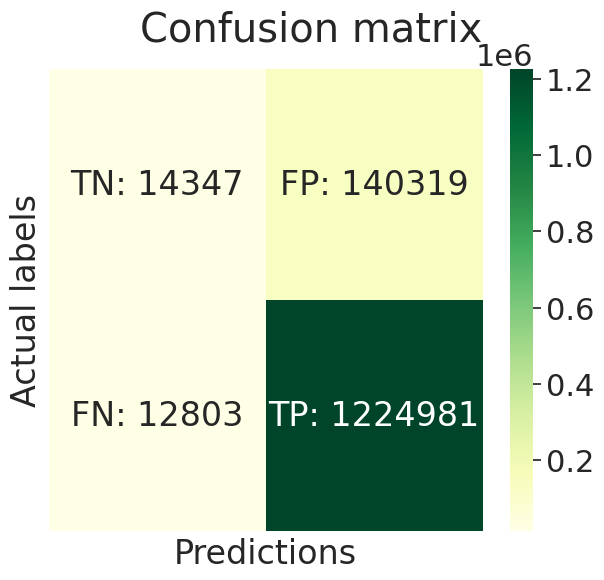

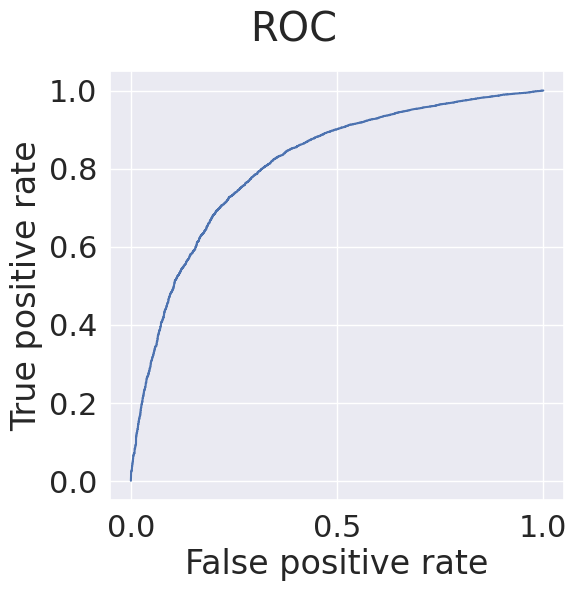

In [ ]:
evaluate(datapath=file_loc, losspath=file_loc, seq_len=75, 
         test_labels=test_labels, img_name="my_image_name", th=0.5)

# References:

1) Thesis: https://helda.helsinki.fi/bitstream/handle/10138/341383/Viljamaa_Venla_thesis_2022.pdf?sequence=2&isAllowed=y

2) Short Explanation: https://data.solita.fi/reading-the-genomic-language-of-dna-using-neural-networks/